In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

environments = ['HalfCheetah-v5', 'Hopper-v5', 'Swimmer-v5', 'Ant-v5', 'Walker2d-v5']
discount_factors = {
    'HalfCheetah-v5': 0.98,
    'Hopper-v5': 0.999,
    'Swimmer-v5': 0.9999,
    'Ant-v5': 0.98,
    'Walker2d-v5': 0.99,
    'ALE/BeamRider-v5': 0.99,
    'ALE/MsPacman-v5': 0.99,
    'ALE/Enduro-v5': 0.99
}

## Plots for evaluative feedback

In [16]:
# Compute statistics env per env (due to memory constraints)
results = {}

# helper function
def discounted_sum_numpy(rewards, discount_factor):
    rewards = np.array(rewards)
    n = len(rewards)
    discount_factors = discount_factor ** np.arange(n)
    return np.sum(rewards * discount_factors)

for env in environments:

    # get all feedback files matching the environment (they contain the name and the seed)
    env_name = env if 'ALE' not in env else env.replace('/', '-')
    feedback_files = [f for f in os.listdir("feedback") if env_name in f]

    # Load data
    for file in feedback_files:
        seed = file.split('.')[0].split('_')[-1]
        with open(f"feedback/{file}", 'rb') as f:
            data = pkl.load(f)
            if env not in results:
                results[env] = []
            
            # compute discounted sum of rewards
            index = np.argsort([discounted_sum_numpy([e[2] for e in d], discount_factors[env]) for d in data["segments"]])
            ordered_gt_rews = np.array([discounted_sum_numpy([e[2] for e in d], discount_factors[env]) for d in data["segments"]])[index]

            # opt gaps
            opt_gaps = -np.array([d for d in data["opt_gaps"]])[index]

            # ratings
            ratings = np.array([d for d in data["ratings"]])[index]

            # demo rewards
            ordered_demo_rews = np.array([discounted_sum_numpy([e[2] for e in d], discount_factors[env]) for d in data["demos"]])[index]

            # store data
            results[env].append((ordered_gt_rews, opt_gaps, ratings, ordered_demo_rews))

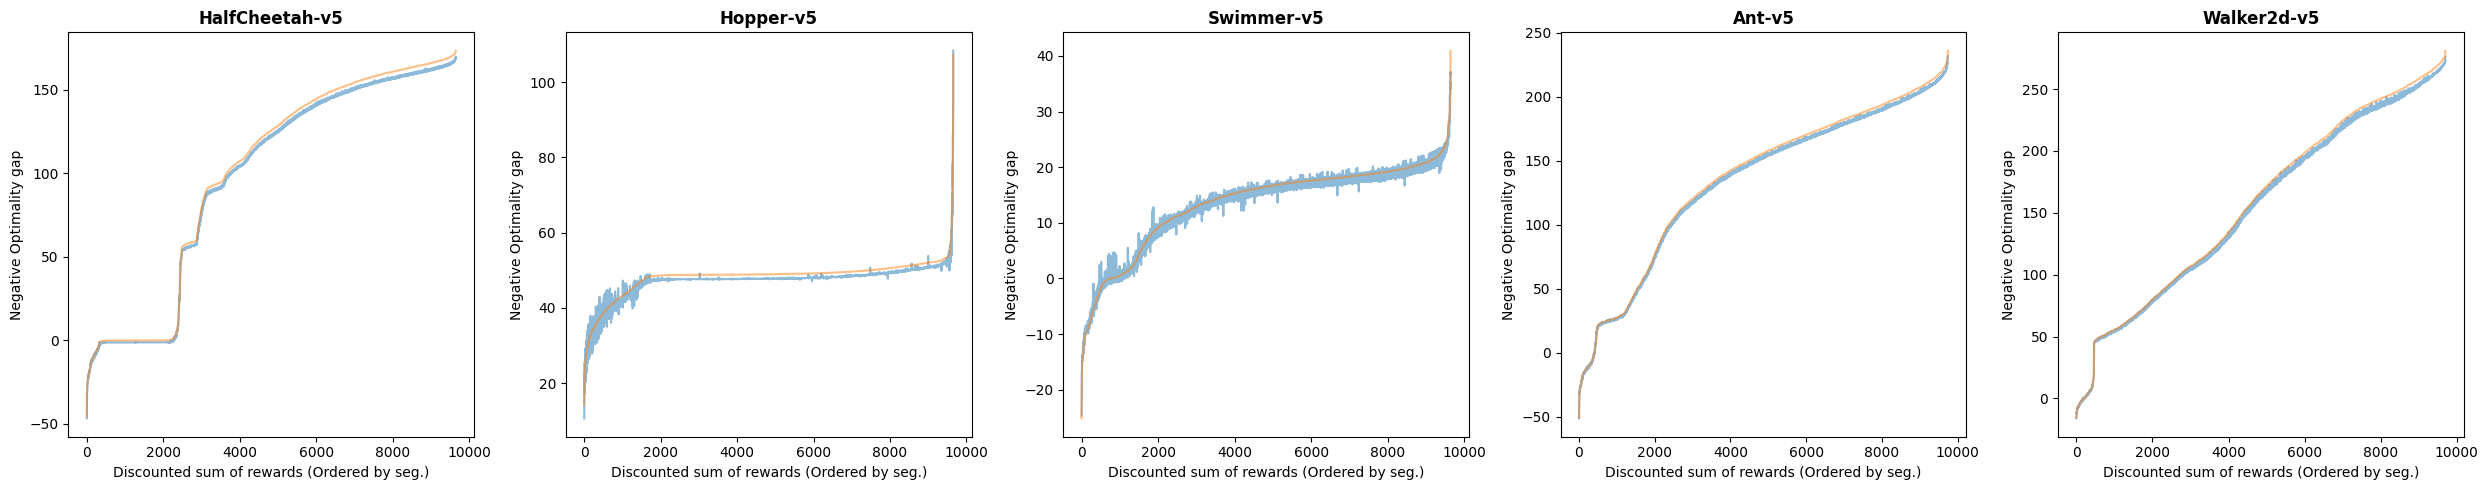

In [17]:
# make grid plot showing opt_gaps (y-axis) vs. discounted sum of rewards (x-axis) for each environment

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, env in enumerate(environments):
    ax = axs[i % 5]
    for data in results[env][:1]:
        ax.plot(data[1], alpha=0.5)
        ax.plot(data[0], alpha=0.5)
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Discounted sum of rewards (Ordered by seg.)")
    ax.set_ylabel("Negative Optimality gap")

plt.tight_layout()

plt.savefig("opt_gaps_vs_discounted_sum_of_rewards.png")

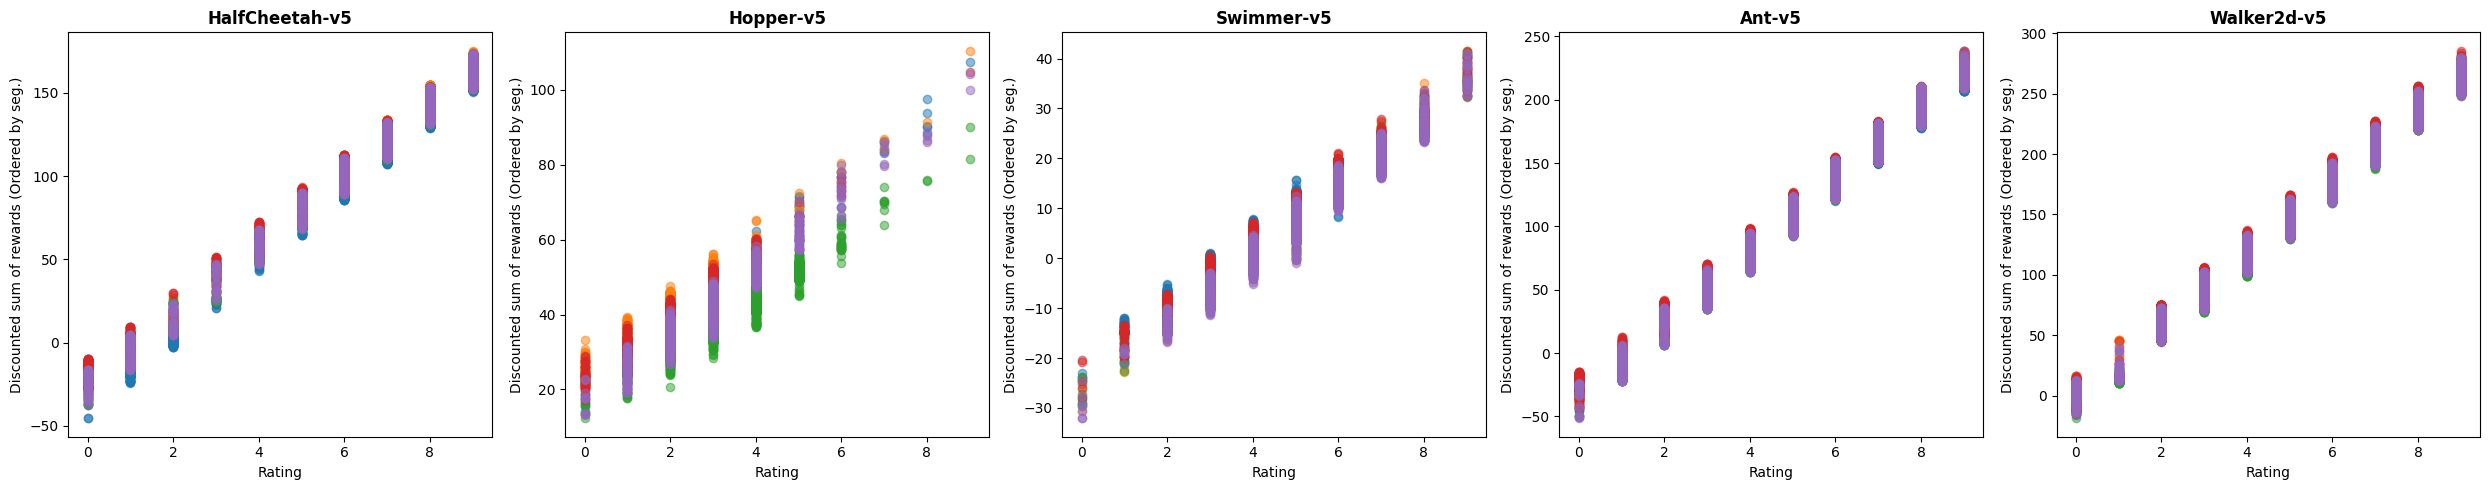

In [18]:
# make grid plot showing ratings (y-axis) vs. discounted sum of rewards (x-axis) for each environment

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, env in enumerate(environments):
    ax = axs[i % 5]
    for data in results[env]:
        ax.plot(data[2], data[0], 'o', alpha=0.5)
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Rating")
    ax.set_ylabel("Discounted sum of rewards (Ordered by seg.)")

plt.tight_layout()

plt.savefig("ratings_vs_discounted_sum_of_rewards.png")

## Plots for demonstrative feedback

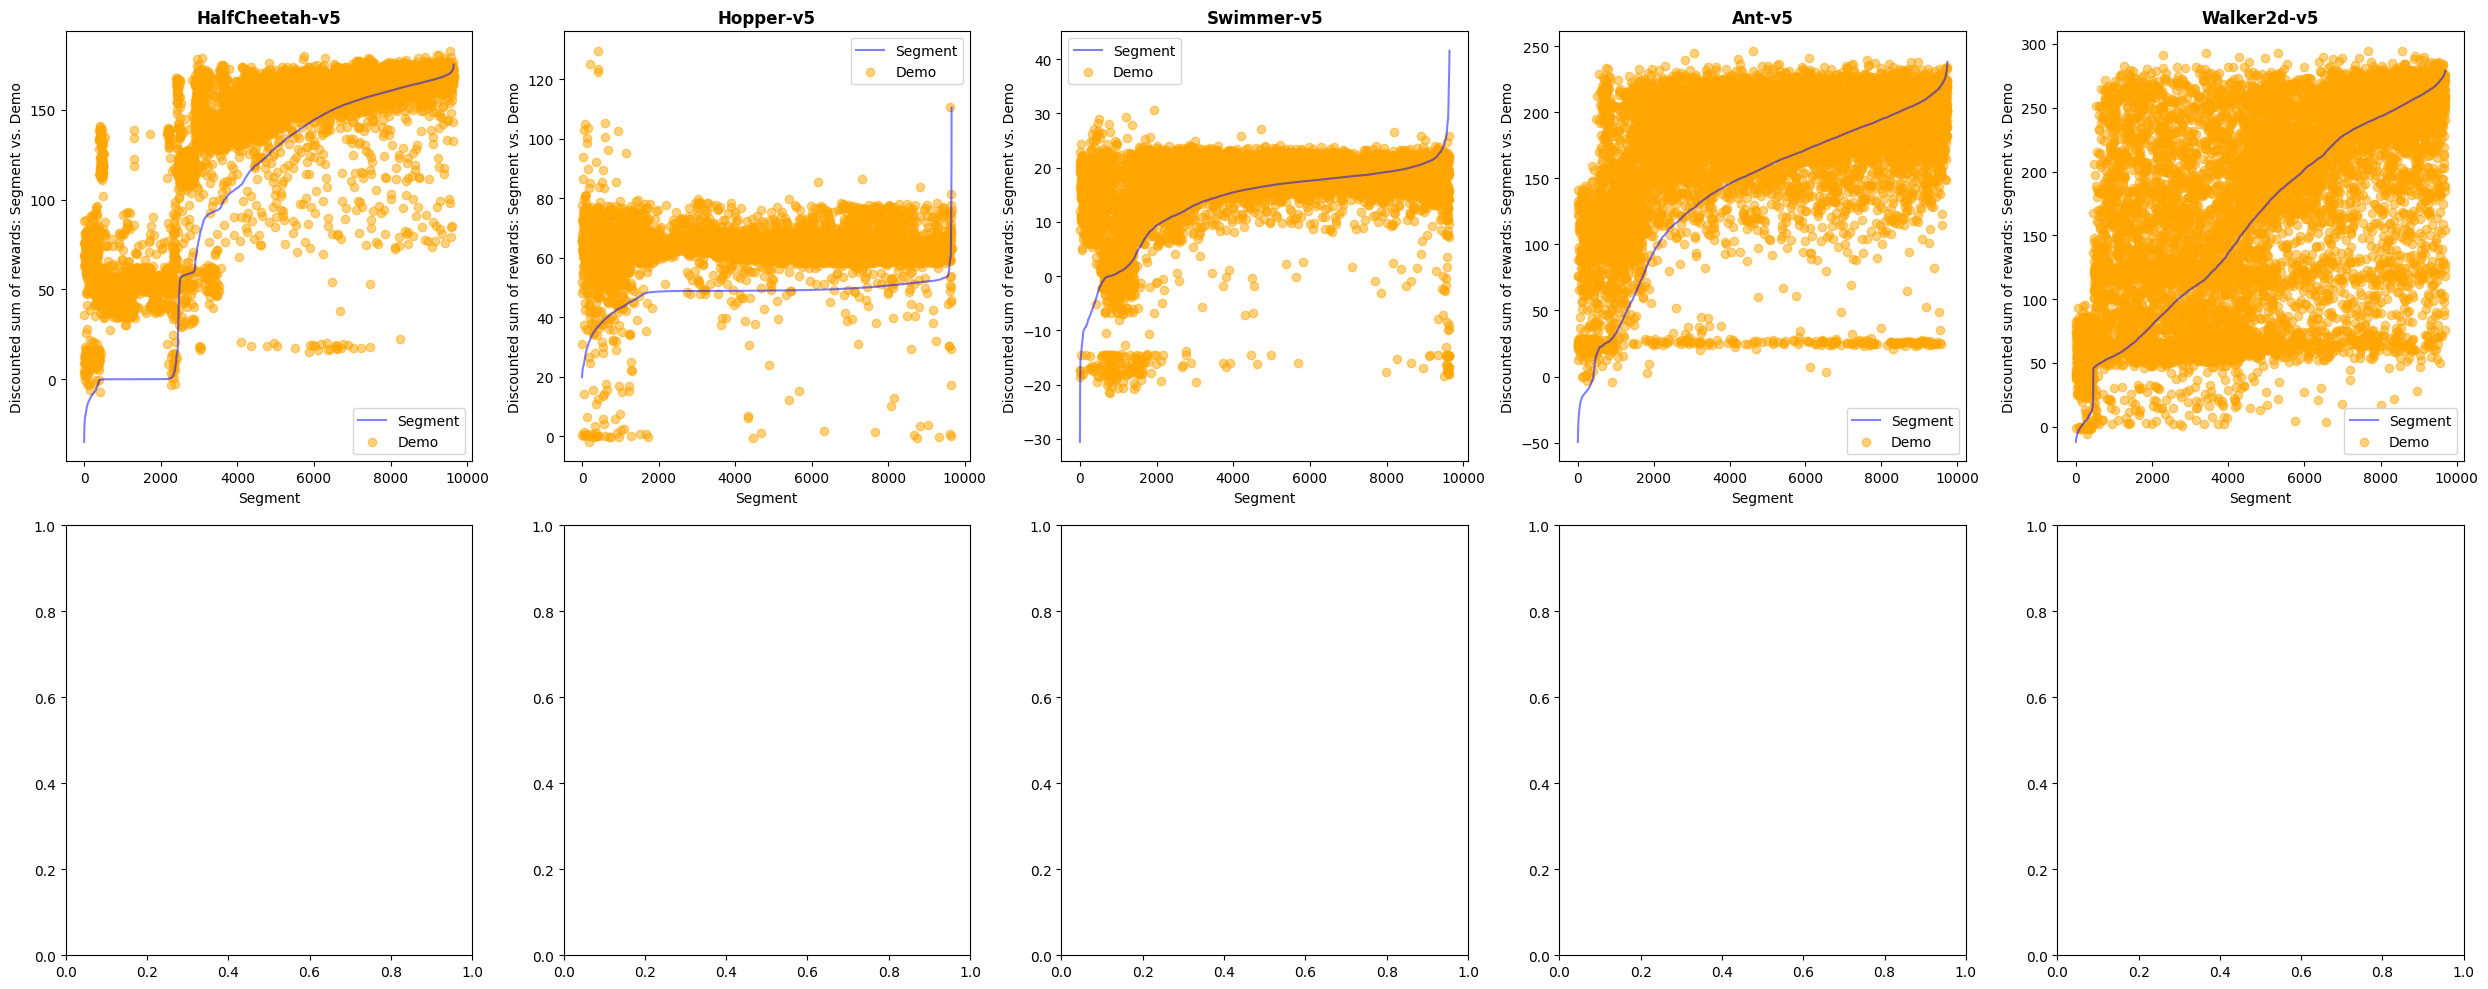

In [19]:
# Instead of ratings, we now want to compare the total rewards between original data ("segments") and demonstrations ("demos").
# make grid plot showing the total rewards for each segment and demo

fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for i, env in enumerate(environments):
    ax = axs[i // 5, i % 5]
    for data in results[env][1:2]:
        steps = np.arange(len(data[0]))
        ax.plot(steps, data[0], label="Segment", alpha=0.5, color='blue')
        ax.scatter(steps, data[3], label="Demo", alpha=0.5, color='orange')
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Segment")
    ax.set_ylabel("Discounted sum of rewards: Segment vs. Demo")
    ax.legend()

plt.tight_layout()

plt.savefig("segment_vs_demo_rewards.png")

In [24]:
# In the feedback_video directory, we have some selected segments. The videos are named according to the scheme "segment_env_seed_segmentindex_optgap.mp4" or "demo_env_seed_segmentindex_optgap.mp4".
# We want to create a plot showing some presentative frames (5 for each video) of the segments and demos (Here ther demos are the corrections). It's fine to just take one seed for each environment.
# Ideally, we want a grid of 5 columns and 2 rows for each environment (one row for the segments and one for the demos). And then save a plot for each environment.

import cv2
os.makedirs("correction_frames", exist_ok=True)

for env in ["Ant-v5", "HalfCheetah-v5", "Walker2d-v5"]:

    # get all feedback files matching the environment (they contain the name and the seed)
    env_name = env if 'ALE' not in env else env.replace('/', '-')
    # get all video files matching the environment and seed
    video_files = [f for f in os.listdir("feedback_videos") if env_name in f and "segment" in f and "mp4" in f]
    demo_files = [f for f in os.listdir("feedback_videos") if env_name in f and "demo" in f and "mp4" in f]

    # we want to find the pair of segment and demo videos that have the same segment index but the highest difference in optgap
    opt_gap_diffs = []
    for file in video_files:
        _, _, _, seed, segindex, optgap = file.split('.')[0].split('_')
        
        # find the corresponding demo video (remember the optgap can be different)
        for video in demo_files:
            if segindex in video:
                _, _, _, seed, segindex, optgap_demo = video.split('.')[0].split('_')
                opt_gap_diffs.append((segindex, file, video, float(optgap)-float(optgap_demo)))
                break

    # sort by the difference in optgap
    opt_gap_diffs = sorted(opt_gap_diffs, key=lambda x: x[2], reverse=True)
    print(opt_gap_diffs)
    
    video_file = opt_gap_diffs[-1][1] #"segment_ppo_HalfCheetah-v5_1337_14_-12.mp4" #opt_gap_diffs[index][0]
    demo_file = opt_gap_diffs[-1][2] #"demo_ppo_HalfCheetah-v5_1337_14_-80.mp4" #opt_gap_diffs[index][1]
    
    cap_seg = cv2.VideoCapture(f"feedback_videos/{video_file}")
    frames_seg = []
    for i in range(5):
        cap_seg.set(cv2.CAP_PROP_POS_FRAMES, i * 10)
        ret, frame = cap_seg.read()
        if ret:
            frames_seg.append(frame)
    cap_seg.release()
    
    cap_demo = cv2.VideoCapture(f"feedback_videos/{demo_file}")
    frames_demo = []
    for i in range(5):
        cap_demo.set(cv2.CAP_PROP_POS_FRAMES, i * 10)
        ret, frame = cap_demo.read()
        if ret:
            frames_demo.append(frame)
    cap_demo.release()

    # plot into a single figure with two rows (title for each row: "Segments" and "Demos")
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    for i, frame in enumerate(frames_seg):
        axs[0, i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axs[0, i].axis('off')

    for i, frame in enumerate(frames_demo):
        axs[1, i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.savefig(f"correction_frames/{env_name}_{seed}_frames.png")
    plt.close()

[('5', 'segment_ppo_Ant-v5_1337_23_-46.mp4', 'demo_ppo_Ant-v5_1337_5_-123.mp4', 77.0), ('2', 'segment_ppo_Ant-v5_1337_12_12.mp4', 'demo_ppo_Ant-v5_1337_2_-122.mp4', 134.0), ('2', 'segment_ppo_Ant-v5_1337_22_-66.mp4', 'demo_ppo_Ant-v5_1337_2_-122.mp4', 56.0), ('27', 'segment_ppo_Ant-v5_1337_15_-41.mp4', 'demo_ppo_Ant-v5_1337_27_-115.mp4', 74.0), ('27', 'segment_ppo_Ant-v5_1337_27_-44.mp4', 'demo_ppo_Ant-v5_1337_27_-115.mp4', 71.0), ('26', 'segment_ppo_Ant-v5_1337_26_-41.mp4', 'demo_ppo_Ant-v5_1337_26_-102.mp4', 61.0), ('25', 'segment_ppo_Ant-v5_1337_25_-42.mp4', 'demo_ppo_Ant-v5_1337_25_-62.mp4', 20.0), ('25', 'segment_ppo_Ant-v5_1337_2_-14.mp4', 'demo_ppo_Ant-v5_1337_25_-62.mp4', 48.0), ('24', 'segment_ppo_Ant-v5_1337_24_-71.mp4', 'demo_ppo_Ant-v5_1337_24_-88.mp4', 17.0), ('20', 'segment_ppo_Ant-v5_1337_20_-62.mp4', 'demo_ppo_Ant-v5_1337_20_-121.mp4', 59.0), ('20', 'segment_ppo_Ant-v5_1337_21_-43.mp4', 'demo_ppo_Ant-v5_1337_20_-121.mp4', 78.0), ('19', 'segment_ppo_Ant-v5_1337_19_-44.mp

## Plots for Descriptive feedback

In [8]:
# two types of plots: fraction of positive/negative attributions vs. discounted sum of rewards (attributions have the same shape and value range as segment observations, let's classify each attribution value as significant
# if it is at least 50% as large as the observation value). Then we count the fraction of significant positive and negative attributions for each segment and plot them against the discounted sum of rewards.

# Compute statistics env per env (due to memory constraints)
results = {}

# helper function
def discounted_sum_numpy(rewards, discount_factor):
    rewards = np.array(rewards)
    n = len(rewards)
    discount_factors = discount_factor ** np.arange(n)
    return np.sum(rewards * discount_factors)

for env in environments:

    # get all feedback files matching the environment (they contain the name and the seed)
    env_name = env if 'ALE' not in env else env.replace('/', '-')
    feedback_files = [f for f in os.listdir("feedback") if env_name in f]

    # Load data
    for file in feedback_files[:1]:
        seed = file.split('.')[0].split('_')[-1]
        with open(f"feedback/{file}", 'rb') as f:
            data = pkl.load(f)
            if env not in results:
                results[env] = []
            
            # compute discounted sum of rewards
            index = np.argsort([np.sum([e[2] for e in d]) for d in data["segments"]])
            ordered_gt_rews = np.array([discounted_sum_numpy([e[2] for e in d], discount_factors[env]) for d in data["segments"]])[index]

            # opt gaps
            attributions = np.array([d[0] for d in data["description"]])[index]
            obs = np.array([np.array([entry[0] for entry in d]) for d in data["segments"]])[index]
            obs_shape = obs[0].squeeze().shape
            #single_attr_score = 
            #significant_pos = np.array([np.sum(np.abs(a) > 0.5 * np.abs(s)) for a, s in zip(attributions, data["segments"])])
            significant_positives = np.array([np.sum(a > 0.05) / np.prod(obs_shape) for a, s in zip(attributions, obs)])
            significant_negatives = np.array([np.sum(a < 0.05) / np.prod(obs_shape) for a, s in zip(attributions, obs)])

            # store data
            results[env].append((ordered_gt_rews, significant_positives, significant_negatives))

        print("done with f.b. file")

KeyError: 'description'

In [ ]:
data["description"][0][0][1].shape

In [ ]:
data["segments"][0][1][0].shape

In [ ]:
fragment_index = 4280
mean_attributions = np.mean([data["description"][fragment_index][0][idx] for idx in range(50)], axis=0)
mean_pattern = np.mean([data["segments"][fragment_index][idx][0] for idx in range(50)], axis=0).squeeze()

for idx in range(50):
    plt.plot(mean_attributions, color="blue", alpha=0.5)
    plt.plot(mean_pattern, color="orange", alpha=0.5)
    plt.plot(mean_pattern * mean_attributions, color="green", alpha=0.5)

In [ ]:
np.abs(mean_attributions).sum()

In [ ]:
# make grid plot showing significant positive attributions (y-axis) vs. discounted sum of rewards (x-axis) for each environment

fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for i, env in enumerate(environments):

    ax = axs[i // 5, i % 5]
    for data in results[env]:
        ax.plot(data[0], data[1], 'o', alpha=0.5)
        b, a = np.polyfit(data[0], data[1], deg=1)
        xseq = np.linspace(np.min(data[0]), np.max(data[0]))
        # Plot regression line
        ax.plot(xseq, a + b * xseq, color="k")
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Discounted sum of rewards")
    ax.set_ylabel("Fraction of positive attributions")

plt.tight_layout()

plt.savefig("significant_positive_attributions_vs_discounted_sum_of_rewards.png")

In [ ]:
# make grid plot showing significant negative attributions (y-axis) vs. discounted sum of rewards (x-axis) for each environment

fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for i, env in enumerate(environments):
    
        ax = axs[i // 5, i % 5]
        for data in results[env]:
            ax.plot(data[0], data[2], 'o', alpha=0.5)
            b, a = np.polyfit(data[0], data[2], deg=1)
            xseq = np.linspace(np.min(data[0]), np.max(data[0]))
            # Plot regression line
            ax.plot(xseq, a + b * xseq, color="k")
        ax.set_title(env, fontweight='bold')
        ax.set_xlabel("Discounted sum of rewards")
        ax.set_ylabel("Fraction of negative attributions")